# Document clustering

## To-do:
  * [LDA](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
  * Parameterise stop words
  * Parameterise lemmatization
  * K-means clustering
  * Hierarchical clustering
  * Dimensionality reduction
  * Visualisation

In [1]:
import pandas as pd
import numpy as np
from time import time

# NLP
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# from sklearn.feature_extraction.text import TfidfVectorizer

## Clustering & Classification
# from sklearn.neighbors import NearestNeighbors

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

In [3]:
df = pd.read_csv('data/amazon_alexa.tsv', sep='\t')

# remove documents with fewer than 5 words
df = df[df['verified_reviews'].apply(lambda x: len(x.split(' '))) >= 5].reset_index(drop=True)

df.head()

,rating,date,variation,verified_reviews,feedback
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1


In [4]:
df.shape

(2502, 5)

## Load language model, punctuation and stopwords

In [5]:
# load (medium-size) English language model and stopwords
nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# list of punctuation
punctuations = string.punctuation

## Custom tokenizer
> See [here](https://github.com/explosion/spaCy/issues/3772#issuecomment-498008841) for using BERT or ELMo embeddings during tokenisation

In [6]:
# creating our tokenizer function
def custom_tokenizer(sentence):
    
    # remove newline chars, punctuation
    exclude = ['\n', '’', *string.punctuation]
    sentence = ''.join(ch for ch in sentence if ch not in exclude)
    
    # creating our token object, which is used to create documents with linguistic annotations.
    tokens = nlp(sentence)

    # lemmatization, lowercase, strip extra whitespace
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
#     tokens = [ w.lower_ for w in tokens ]

    # remove stopwords
    tokens = [ w for w in tokens if w not in stop_words ]

    # return preprocessed list of tokens
    return tokens

## TFIDF vectorisation
> [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# perform tfidf vectorisation using custom SpaCy tokenizer
vec = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    ngram_range=(1,2),  # allow bi-grams
    max_features=1500
)

In [9]:
X = vec.fit_transform(df['verified_reviews'])

In [10]:
X.toarray().shape

(2502, 1500)

In [11]:
X = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
X.head()

,,,3,5,able,alarm,alexa,amazing,amazon,ask,...,year,year old,yell,yes,youtube,youtube video,—,👍,😁,😁 😁
0,0.100700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.235544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## K-means

In [12]:
from sklearn.cluster import KMeans

In [13]:
# let's try everything between 1 and 20 clusters
n_clusters = np.arange(1, 21)

# store errors for each value of k
errors = []

# for i between 1 and 20
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(X)
    # measure WCSS
    errors.append(km.inertia_)

### Determine number of clusters

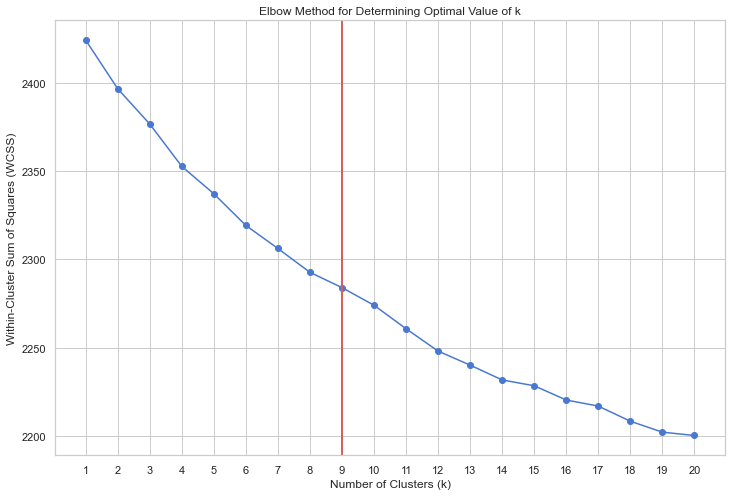

In [14]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)

# SET THE X-VALUE BELOW TO THE NUMBER OF CLUSTERS
# AT WHICH THE ELBOW OCCURS
plt.axvline(x=9, color='r', lw=2)
plt.show()

In [15]:
# set number of clusters based on elbow plot
k = 8

km = KMeans(n_clusters=k, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(random_state=42)
done in 2.629s


In [16]:
# add cluster labels to df
df['tfidf_cluster'] = km.labels_ + 1

df.head(10)

,rating,date,variation,verified_reviews,feedback,tfidf_cluster
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,4
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,4
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,4
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,6
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,4
5,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1,4
6,5,30-Jul-18,Charcoal Fabric,"I sent it to my 85 year old Dad, and he talks ...",1,4
7,5,30-Jul-18,Charcoal Fabric,I love it! Learning knew things with it eveyda...,1,4
8,5,30-Jul-18,Oak Finish,I purchased this for my mother who is having k...,1,4
9,5,30-Jul-18,Heather Gray Fabric,"I love it, wife hates it.",1,3


In [17]:
# show cluster sizes
df[['tfidf_cluster']].value_counts()

tfidf_cluster
4                959
6                404
1                259
3                233
2                225
5                170
7                169
8                 83
dtype: int64

In [18]:
df.to_csv('./tfidf_output.csv', index=False)

In [19]:
df[df['tfidf_cluster']==7]['verified_reviews'].head(20)

10     Really happy with this purchase.  Great speake...
43     Works as advertised. Very easy to setup. Still...
44                       Great sound and easy to set up.
51                            How easy if was to set up.
56     Great sound in a small package—easy to set up ...
80     Very easy to set up. Works wonderful and I lov...
87     Easy to set up and use. Too bad it has to be p...
98     It was very easy to set up and my family love ...
121    Met and exceeded my expectations. Easy set up ...
135        Super easy set up and am loving our new Echo!
143                       Easy set up very user friendly
185    I received the echo in perfect condition. The ...
199         Easy to setup. Love all the things she does.
226              Very easy to set up and have no issues.
253                 Very easy set up. Really enjoying it
265    Easy setup using the app, which was also easy ...
351                The simplicity of use and setting up.
378    It arrived quickly and w

## Dimensionality reduction

In [20]:
from sklearn.manifold import MDS

In [21]:
mds = MDS(n_components=2, 
          n_init=2, 
          max_iter=200,
          n_jobs=-1,
          random_state=42,
          dissimilarity='euclidean')

print('Computing MDS...')
t0 = time()
X_mds = mds.fit_transform(X)
print(f'Completed in {time() - t0} seconds, Stress: {mds.stress_}')

Computing MDS...
Completed in 76.24251341819763 seconds, Stress: 1062703.9955881722


In [22]:
df['mds_1'] = X_mds[:,0]
df['mds_2'] = X_mds[:,1]

df.head()

,rating,date,variation,verified_reviews,feedback,tfidf_cluster,mds_1,mds_2
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,4,0.005135,0.886390
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,4,-0.765854,-0.394657
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,4,-0.256418,-0.881273
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,6,-0.489539,-0.551564
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,4,-0.647705,-0.516807


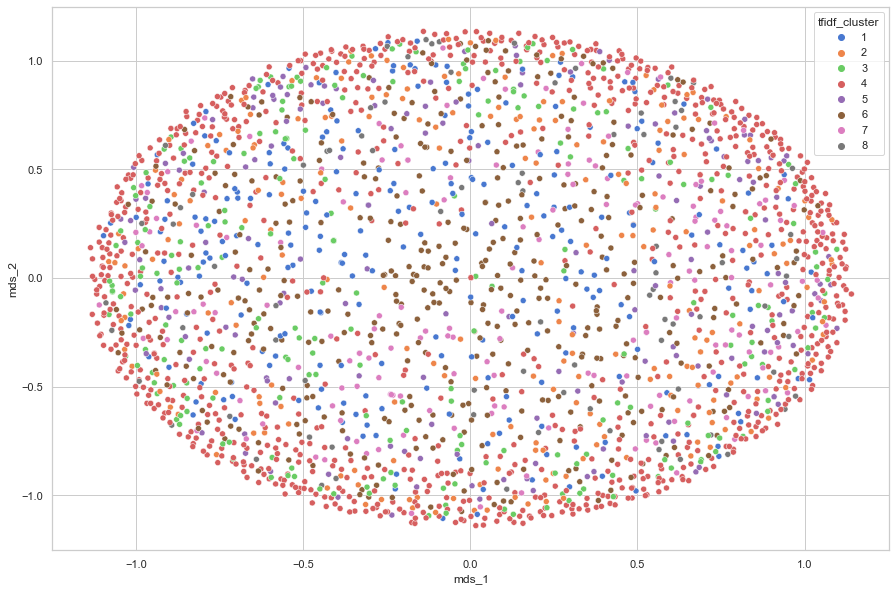

In [24]:
ax = sns.scatterplot(x='mds_1', y='mds_2', hue='tfidf_cluster', data=df, palette=sns.color_palette(n_colors=k))
plt.show()

## Visualisation

## Document vector similarity

In [16]:
# get document vectors for each card
X = np.vstack([i for i in df['verified_reviews'].apply(lambda x: nlp(x).vector)])

In [18]:
X.shape

(3150, 300)

In [14]:
nbrs = NearestNeighbors(n_neighbors=4, metric='cosine', n_jobs=-1).fit(X)

distances, indices = nbrs.kneighbors(X)

# add columns for 3 nearest neighbours
for i in range(1,4):
    df[f's_{i}'] = indices[:,i]
    df[f's_{i}_dist'] = distances[:,i]
    
df.head(10)

,rating,date,variation,verified_reviews,feedback,nn_1,nn_1_dist,nn_2,nn_2_dist,nn_3,nn_3_dist,s_1,s_1_dist,s_2,s_2_dist,s_3,s_3_dist
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,265,0.000000,960,0.000000,825,0.000000,1069,3.196222e-02,1095,0.031962,1568,0.032799
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,461,0.000000,1366,0.000000,2182,0.000000,461,4.017389e-02,2239,0.040174,1412,0.040174
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,441,0.520152,2578,0.538588,2929,0.538588,1322,2.097732e-02,1440,0.021285,1380,0.021410
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,2623,0.574790,2974,0.574790,2401,0.586791,1472,3.344595e-02,702,0.034653,7,0.034653
4,5,31-Jul-18,Charcoal Fabric,Music,1,2885,0.293424,2534,0.293424,1158,0.382815,781,1.658735e-01,86,0.165874,937,0.244975
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,700,0.000000,3127,0.565112,2776,0.565112,5,4.768372e-07,1828,0.017202,258,0.018035
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,701,0.000000,1228,0.672364,330,0.677549,6,0.000000e+00,953,0.012108,258,0.012108
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,702,0.000000,987,0.578247,292,0.578247,7,2.384186e-07,1256,0.021797,1515,0.022419
8,5,30-Jul-18,Heather Gray Fabric,looks great,1,8,0.000000,703,0.000000,1858,0.354330,703,0.000000e+00,1465,0.117256,1793,0.125488
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1,704,0.000000,1599,0.471810,2817,0.544518,704,0.000000e+00,231,0.039261,926,0.039261


## Compare results

In [15]:
def show_nearest(dataframe, idx, cosine=True):
    
    cols = ['s_1', 's_2', 's_3']
    if cosine:
        cols = ['nn_1', 'nn_2', 'nn_3']
    
    print(f'Rating = {dataframe.loc[idx, "rating"]}')
    print('Text:', dataframe.loc[idx, 'verified_reviews'], sep='\n', end='\n\n')
    
    for i in cols:
        nn = dataframe.loc[idx, i]
        
        print(f'{i}, Distance = {dataframe.loc[idx, i+"_dist"]:.2f}, Rating = {dataframe.loc[idx, "rating"]}')
        print('Text:', dataframe.loc[nn, 'verified_reviews'], sep='\n', end='\n\n')

In [16]:
# show tfidf and embedding results for first 5 articles
for i in range(5):
    print('-'*30, 'DOCUMENT', i+1, 'TFIDF', '-'*30)
    show_nearest(df, i)
    print('-'*35, 'EMBEDDING', '-'*35)
    show_nearest(df, i, cosine=False)
    print('-'*40, '-'*40, '\n')

------------------------------ DOCUMENT 1 TFIDF ------------------------------
Rating = 5
Text:
Love my Echo!

nn_1, Distance = 0.00, Rating = 5
Text:
Love my Echo

nn_2, Distance = 0.00, Rating = 5
Text:
Love my Echo

nn_3, Distance = 0.00, Rating = 5
Text:
Love our echo

----------------------------------- EMBEDDING -----------------------------------
Rating = 5
Text:
Love my Echo!

s_1, Distance = 0.03, Rating = 5
Text:
Love my Echo Spot!

s_2, Distance = 0.03, Rating = 5
Text:
Love my Echo Spot!

s_3, Distance = 0.03, Rating = 5
Text:
Love my echo show!

---------------------------------------- ---------------------------------------- 

------------------------------ DOCUMENT 2 TFIDF ------------------------------
Rating = 5
Text:
Loved it!

nn_1, Distance = 0.00, Rating = 5
Text:
Love it!

nn_2, Distance = 0.00, Rating = 5
Text:
Love it

nn_3, Distance = 0.00, Rating = 5
Text:
Love it love it love it

----------------------------------- EMBEDDING ----------------------------------